In [10]:

import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", palette="deep")

ROOT_DIR = Path("..").resolve()
if str(ROOT_DIR) not in sys.path:
    sys.path.append(str(ROOT_DIR))

from src import theory, NetworkConfig, NetworkAgentModel

output_dir = ROOT_DIR / 'outputs'
output_dir.mkdir(exist_ok=True)

data_dir = output_dir / 'data'
fig_dir = output_dir / 'figs'
data_dir.mkdir(parents=True, exist_ok=True)
fig_dir.mkdir(parents=True, exist_ok=True)

phi, theta = 0.54, 0.46
TARGET_SAMPLE_N = 50  # 理论/模拟统一采样数
n_m, n_w = 10, 5
BETA = 0.2  # 邻居耦合强度，非零以体现拓扑差异

chi_ref = theory.calculate_chi(phi, theta, k_avg=TARGET_SAMPLE_N)
rc_ref = theory.calculate_rc(n_m, n_w, chi_ref)
print(f"Theory Reference: chi={chi_ref:.4f}, rc={rc_ref:.4f}, sample_n={TARGET_SAMPLE_N}")


Theory Reference: chi=9.5962, rc=0.6725, sample_n=50


Running Ultimate Theory Validation (Q & A)...
Simulating k=50 (Dense)...
Saved results to E:\newdesktop\emotion_dynamics\outputs\data\rq_a_scan_k50_fixed.npz


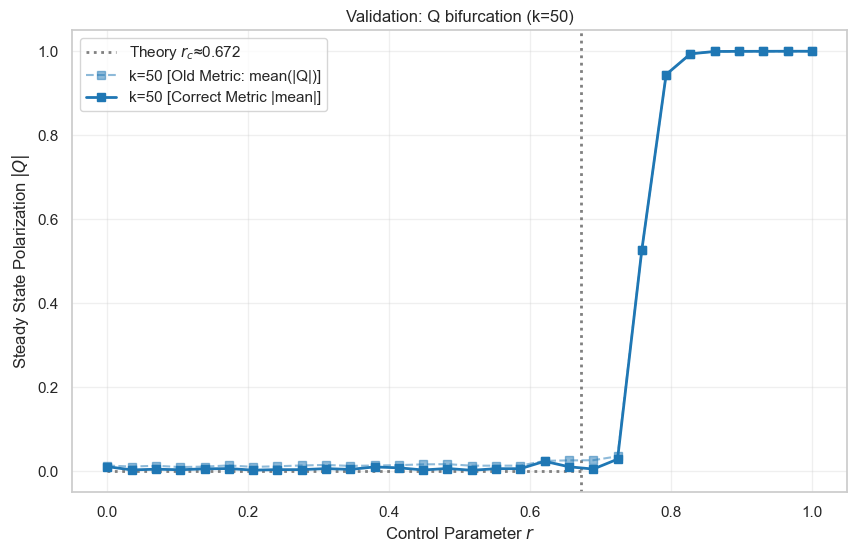

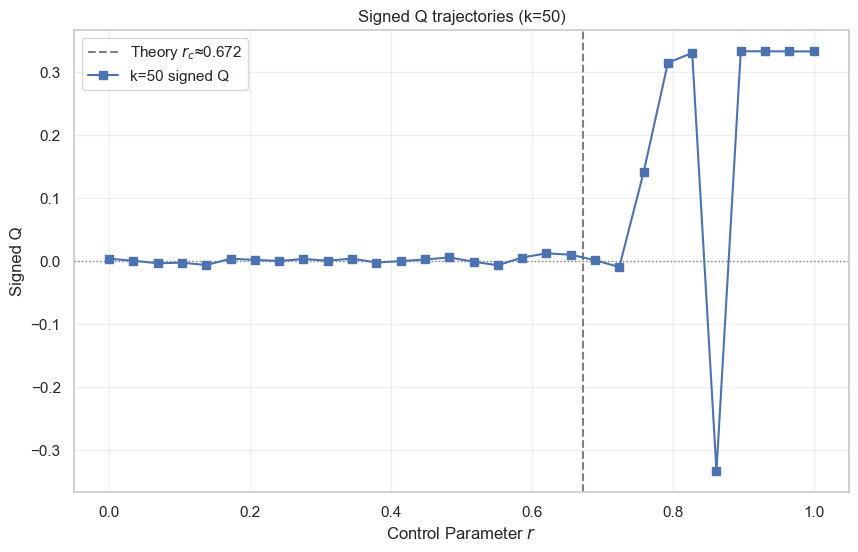

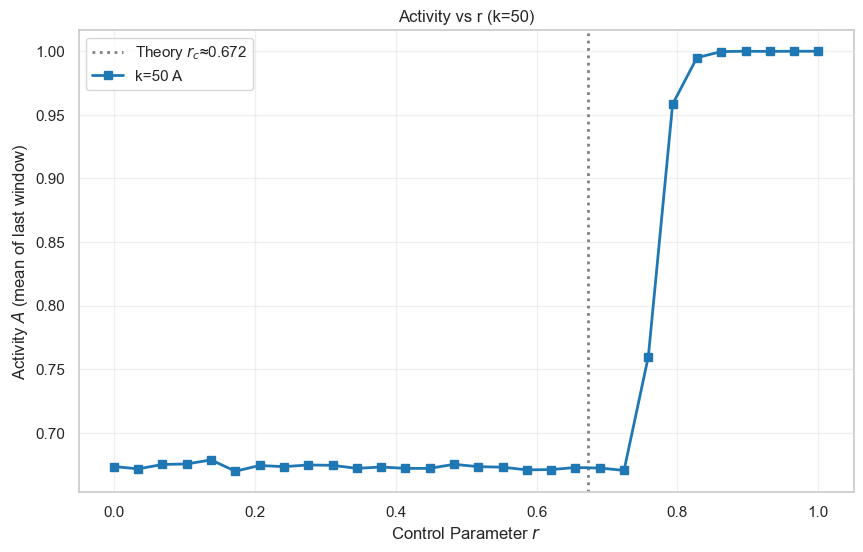

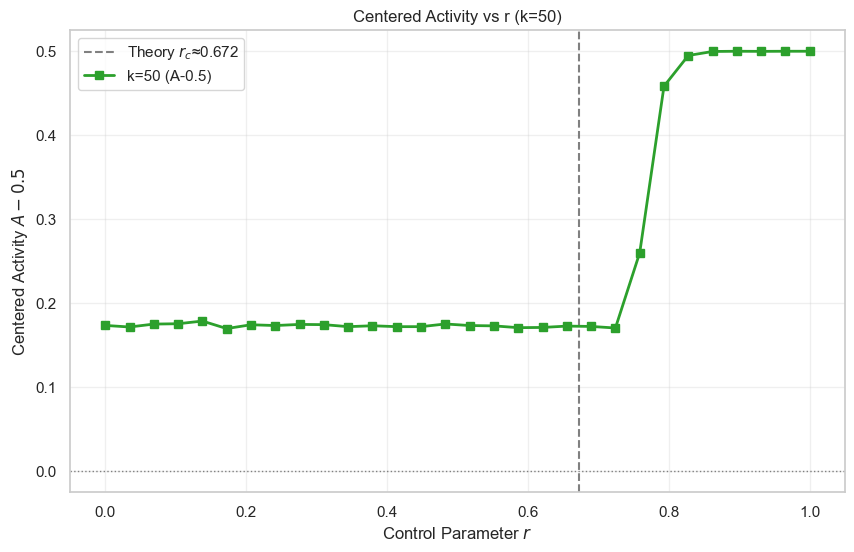

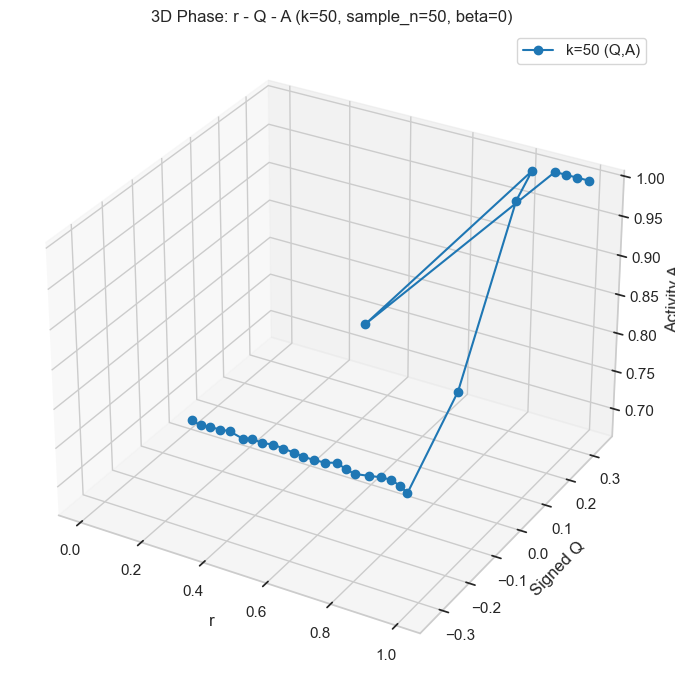

In [11]:

import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# 路径与导入
action_root = Path('..').resolve()
if str(action_root) not in sys.path:
    sys.path.append(str(action_root))

import numpy as np
import matplotlib.pyplot as plt
from src.network_sim import NetworkAgentModel, NetworkConfig
from src import theory

# 理论参考
phi, theta = 0.54, 0.46
n_m, n_w = 10, 5
chi_ref = theory.calculate_chi(phi, theta, k_avg=TARGET_SAMPLE_N)
rc_ref = theory.calculate_rc(n_m, n_w, chi_ref)

# 实验参数
N = 500
r_scan = np.linspace(0, 1.0, 30)
beta_fixed = 0.0 # 保持无耦合，验证理论基准
seeds = [0, 1, 2] 
steps = 300

# 拓扑配置（仅 k=50）
topology_setups = [
    {'k': 50,  'label': 'k=50 (Dense)', 'fmt': 's-'}
]

results = {cfg['label']: {'abs_mean': [], 'mean_abs': [], 'signed_mean': [], 'a_mean': [], 'a_signed': []} for cfg in topology_setups}
cache_path = data_dir / 'rq_a_scan_k50_fixed.npz'
print("Running Ultimate Theory Validation (Q & A)...")

if cache_path.exists():
    loaded = np.load(cache_path)
    r_scan = loaded['r_scan']
    res = results['k=50 (Dense)']
    res['abs_mean'] = loaded['abs_mean']
    res['mean_abs'] = loaded['mean_abs']
    res['signed_mean'] = loaded['signed_mean']
    res['a_mean'] = loaded['a_mean']
    res['a_signed'] = loaded['a_signed']
    print('Loaded cached results from', cache_path)
else:
    for cfg in topology_setups:
        k = cfg['k']
        print(f"Simulating {cfg['label']}...")
        q_mean_abs_list = []  # 先取绝对值
        q_abs_mean_list = []  # 先平均再取绝对值
        q_signed_list = []    # 带符号
        a_mean_list = []      # 活跃度平均
        a_signed_list = []    # 活跃度相对中性点(0.5)的偏移

        for r in r_scan:
            q_ma_seeds = []
            q_am_seeds = []
            q_signed_seeds = []
            a_seeds = []
            a_signed_seeds = []
            for seed in seeds:
                net_cfg = NetworkConfig(
                    n=N, avg_degree=k, model="er", beta=beta_fixed,
                    r=r, n_m=n_m, n_w=n_w, phi=phi, theta=theta, seed=seed,
                    init_state="medium", sample_mode="fixed", sample_n=TARGET_SAMPLE_N,
                )
                model = NetworkAgentModel(net_cfg)
                _, q_traj, a_traj = model.run(steps=steps, record_interval=50)

                steady_q = q_traj[-5:]
                steady_a = a_traj[-5:]
                q_ma_seeds.append(np.mean(np.abs(steady_q)))
                q_am_seeds.append(np.abs(np.mean(steady_q)))
                q_signed_seeds.append(np.mean(steady_q))
                a_seeds.append(np.mean(steady_a))
                a_signed_seeds.append(np.mean(steady_a - 0.5))

            q_mean_abs_list.append(np.mean(q_ma_seeds))
            q_abs_mean_list.append(np.mean(q_am_seeds))
            q_signed_list.append(np.mean(q_signed_seeds))
            a_mean_list.append(np.mean(a_seeds))
            a_signed_list.append(np.mean(a_signed_seeds))

        results[cfg['label']]['mean_abs'] = np.array(q_mean_abs_list)
        results[cfg['label']]['abs_mean'] = np.array(q_abs_mean_list)
        results[cfg['label']]['signed_mean'] = np.array(q_signed_list)
        results[cfg['label']]['a_mean'] = np.array(a_mean_list)
        results[cfg['label']]['a_signed'] = np.array(a_signed_list)

    # 保存缓存
    res = results['k=50 (Dense)']
    np.savez(cache_path, r_scan=r_scan, abs_mean=res['abs_mean'], mean_abs=res['mean_abs'], signed_mean=res['signed_mean'], a_mean=res['a_mean'], a_signed=res['a_signed'])
    print('Saved results to', cache_path)

# --- 绘图验证：|Q| ---
plt.figure(figsize=(10, 6))
plt.axvline(rc_ref, color='gray', linestyle=':', linewidth=2, label=fr'Theory $r_c$≈{rc_ref:.3f}')
plt.hlines(0, 0, rc_ref, colors='gray', linestyles=':', linewidth=2)
res_k50 = results['k=50 (Dense)']
plt.plot(r_scan, res_k50['mean_abs'], 's--', color='tab:blue', alpha=0.5,
         label='k=50 [Old Metric: mean(|Q|)]')
plt.plot(r_scan, res_k50['abs_mean'], 's-', color='tab:blue', linewidth=2,
         label='k=50 [Correct Metric |mean|]')
plt.xlabel('Control Parameter $r$')
plt.ylabel('Steady State Polarization $|Q|$')
plt.title('Validation: Q bifurcation (k=50)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- 绘图验证：Signed Q ---
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle=':', linewidth=1)
plt.axvline(rc_ref, color='gray', linestyle='--', label=fr'Theory $r_c$≈{rc_ref:.3f}')
plt.plot(r_scan, results['k=50 (Dense)']['signed_mean'], 's-', label='k=50 signed Q')
plt.xlabel('Control Parameter $r$')
plt.ylabel('Signed Q')
plt.title('Signed Q trajectories (k=50)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- 绘图验证：A (活动度) ---
plt.figure(figsize=(10, 6))
plt.axvline(rc_ref, color='gray', linestyle=':', linewidth=2, label=fr'Theory $r_c$≈{rc_ref:.3f}')
plt.plot(r_scan, results['k=50 (Dense)']['a_mean'], 's-', color='tab:blue', linewidth=2, label='k=50 A')
plt.xlabel('Control Parameter $r$')
plt.ylabel('Activity $A$ (mean of last window)')
plt.title('Activity vs r (k=50)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- 绘图验证：A 偏移 (Signed, 中心化到0) ---
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle=':', linewidth=1)
plt.axvline(rc_ref, color='gray', linestyle='--', label=fr'Theory $r_c$≈{rc_ref:.3f}')
plt.plot(r_scan, results['k=50 (Dense)']['a_signed'], 's-', color='tab:green', linewidth=2, label='k=50 (A-0.5)')
plt.xlabel('Control Parameter $r$')
plt.ylabel('Centered Activity $A-0.5$')
plt.title('Centered Activity vs r (k=50)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- 3D 相图：r - Signed Q - A ---
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')
r_vals = r_scan
q_vals = results['k=50 (Dense)']['signed_mean']
a_vals = results['k=50 (Dense)']['a_mean']
ax.plot(r_vals, q_vals, a_vals, marker='o', color='tab:blue', label='k=50 (Q,A)')
ax.set_xlabel('r')
ax.set_ylabel('Signed Q')
ax.set_zlabel('Activity A')
ax.set_title('3D Phase: r - Q - A (k=50, sample_n=50, beta=0)')
ax.legend()
plt.tight_layout()
plt.show()


In [12]:
from src import theory

# 你的模型参数
phi, theta = 0.54, 0.46
n_m, n_w = 10, 5

# 情况 1：你现在的参照线 (k=50)
chi_50 = theory.calculate_chi(phi, theta, k_avg=50)
rc_50 = theory.calculate_rc(n_m, n_w, chi_50)
print(f"Theory r_c (k=50):   {rc_50:.4f}")

# 情况 2：你模拟的真实情况 (k=1999, Full Mesh N=2000)
chi_2000 = theory.calculate_chi(phi, theta, k_avg=1999)
rc_2000 = theory.calculate_rc(n_m, n_w, chi_2000)
print(f"Theory r_c (k=1999): {rc_2000:.4f}")

Theory r_c (k=50):   0.6725
Theory r_c (k=1999): 1.4401



## 附录：有限尺寸效应 (Finite-Size Scaling)

**目标**：验证随着系统规模 N 增大，模拟的 $r_c$ 趋近于理论预测值。


In [ ]:

# 有限尺寸效应验证
import numpy as np
import matplotlib.pyplot as plt
from src.network_sim import NetworkAgentModel, NetworkConfig

# 参数
phi, theta = 0.54, 0.46
n_m, n_w = 10, 5
k_avg = 50
seed = 42

# 理论 rc
from src import calculate_chi, calculate_rc
chi = calculate_chi(phi, theta, k_avg)
rc_theory = float(calculate_rc(n_m, n_w, chi))
print(f"理论 rc = {rc_theory:.4f}")

# 扫描不同的 N
N_list = [100, 200, 500, 1000, 2000]
rc_measured = []

r_scan = np.linspace(0.5, 1.0, 20)  # 聚焦于 rc 附近

for N in N_list:
    q_means = []
    for r in r_scan:
        cfg = NetworkConfig(
            n=N,
            avg_degree=min(k_avg, N-1),  # 确保 k < N
            model="er",
            beta=0.0,
            r=r,
            n_m=n_m,
            n_w=n_w,
            phi=phi,
            theta=theta,
            seed=seed,
            init_state="medium",
            sample_mode="fixed",
            sample_n=min(k_avg, N-1),
            symmetric_mode=True,
        )
        model = NetworkAgentModel(cfg)
        t, q_traj, _ = model.run(steps=300, record_interval=10)
        q_means.append(np.mean(np.abs(q_traj[-5:])))
    
    q_means = np.array(q_means)
    # 找到 |Q| 开始上升的点作为 rc 估计
    threshold = 0.1
    idx = np.where(q_means > threshold)[0]
    if len(idx) > 0:
        rc_est = r_scan[idx[0]]
    else:
        rc_est = np.nan
    rc_measured.append(rc_est)
    print(f"N={N}: rc_est ≈ {rc_est:.3f}")

# 绘图
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(N_list, rc_measured, 'o-', markersize=10, linewidth=2, label='Simulation')
ax.axhline(rc_theory, color='red', linestyle='--', linewidth=2, label=f'Theory $r_c$={rc_theory:.3f}')
ax.set_xlabel('System size N', fontsize=12)
ax.set_ylabel('Estimated $r_c$', fontsize=12)
ax.set_title('Finite-Size Scaling: $r_c$ vs N', fontsize=13)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xscale('log')
fig.tight_layout()
plt.show()

print(f"\n结论：随着 N 增大，模拟 rc 趋向理论值 {rc_theory:.3f}")
